In [1]:
!apt update
!apt -y install ffmpeg

Hit:1 http://archive.ubuntu.com/ubuntu xenial InRelease
Get:2 http://archive.ubuntu.com/ubuntu xenial-updates InRelease [99.8 kB]      
Get:4 http://archive.ubuntu.com/ubuntu xenial-backports InRelease [97.4 kB]0m  
Err:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease3m
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Get:5 http://security.ubuntu.com/ubuntu xenial-security InRelease [99.8 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Reading package lists... Done                        
W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
E: The repository 'http

In [2]:
!wget -c https://files.deeppavlov.ai/field-matters/releases/demo/asr_data.csv
!wget -c https://files.deeppavlov.ai/field-matters/releases/demo/sound.zip
!unzip sound.zip

--2022-06-02 07:02:00--  https://files.deeppavlov.ai/field-matters/releases/demo/asr_data.csv
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 10.11.1.254
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|10.11.1.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 334717 (327K) [application/octet-stream]
Saving to: ‘asr_data.csv’

asr_data.csv        100%[===================>] 326.87K  --.-KB/s    in 0.02s   

2022-06-02 07:02:01 (16.3 MB/s) - ‘asr_data.csv’ saved [334717/334717]

--2022-06-02 07:02:01--  https://files.deeppavlov.ai/field-matters/releases/demo/sound.zip
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 10.11.1.254
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|10.11.1.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1198165394 (1.1G) [application/zip]
Saving to: ‘sound.zip’

sound.zip           100%[===================>]   1.12G   260MB/s    in 4.9s    

2022-06-02 07:02:06 (235 MB/s) - ‘s

In [3]:
import pandas as pd
import os
import re
from tqdm.auto import tqdm
tqdm.pandas()

In [11]:
df = pd.read_csv('asr_data.csv') #your dataset here

In [12]:
df["fpath"] = './audio_to_release/' + df["lang"].astype(str) + "/" + df["source"].astype(str)
df

,start,end,transcription,source,lang,fpath
0,4.260,7.113,"«Myaryosiw tina (Myaryosiw ti),",es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
1,7.116,9.642,sawa nyeǣǣy (săwă nye).,es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
2,16.638,19.785,"Pada ni yutʃitʹq (Pida ni yusidaq),",es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
3,19.787,22.974,pirye yesyada tănya (pirye yesyada tănya).,es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
4,94.893,97.867,"Săwawna macraaa (săwawna măncara),",es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
...,...,...,...,...,...,...
3207,28.476,29.481,gunən.,2011_Potapovo_Bogdanova_Tamara_Andreevna_FM2-2...,evn,./audio_to_release/evn/2011_Potapovo_Bogdanova...
3208,29.902,33.549,ēlā əto ēlā bəjə odantə̄.,2011_Potapovo_Bogdanova_Tamara_Andreevna_FM2-2...,evn,./audio_to_release/evn/2011_Potapovo_Bogdanova...
3209,34.548,38.193,a əto bəjəl gunďərəØ.,2011_Potapovo_Bogdanova_Tamara_Andreevna_FM2-2...,evn,./audio_to_release/evn/2011_Potapovo_Bogdanova...
3210,39.221,40.906,ŋinakin əmərən.,2011_Potapovo_Bogdanova_Tamara_Andreevna_FM2-2...,evn,./audio_to_release/evn/2011_Potapovo_Bogdanova...


In [13]:
#adding paths to file to dataset
df["fpath"] = './audio_to_release/' + df["lang"].astype(str) + "/" + df["source"].astype(str)
#removing spaces in dataset's paths
cache = {}
def fix_path(path):
    try:
        new_path = path.replace(' ', '_')
        new_path = cache.setdefault(path, new_path)
        if not os.path.exists(new_path):
            os.rename(path, new_path)
        return new_path
    except Exception as e:
        print(e)
df['fpath'] = df['fpath'].apply(fix_path)

df = df.reset_index() #adding indexes(id)

In [14]:
def replacer(path):
    return path.replace(' ', '_')
df['fpath'] = df['fpath'].apply(replacer)
df = df.reset_index() #adding indexes(id)
df

,level_0,index,start,end,transcription,source,lang,fpath
0,0,0,4.260,7.113,"«Myaryosiw tina (Myaryosiw ti),",es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
1,1,1,7.116,9.642,sawa nyeǣǣy (săwă nye).,es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
2,2,2,16.638,19.785,"Pada ni yutʃitʹq (Pida ni yusidaq),",es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
3,3,3,19.787,22.974,pirye yesyada tănya (pirye yesyada tănya).,es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
4,4,4,94.893,97.867,"Săwawna macraaa (săwawna măncara),",es100708_MatjPelaNEN.WAV,yrk,./audio_to_release/yrk/es100708_MatjPelaNEN.WAV
...,...,...,...,...,...,...,...,...
3207,3207,3207,28.476,29.481,gunən.,2011_Potapovo_Bogdanova_Tamara_Andreevna_FM2-2...,evn,./audio_to_release/evn/2011_Potapovo_Bogdanova...
3208,3208,3208,29.902,33.549,ēlā əto ēlā bəjə odantə̄.,2011_Potapovo_Bogdanova_Tamara_Andreevna_FM2-2...,evn,./audio_to_release/evn/2011_Potapovo_Bogdanova...
3209,3209,3209,34.548,38.193,a əto bəjəl gunďərəØ.,2011_Potapovo_Bogdanova_Tamara_Andreevna_FM2-2...,evn,./audio_to_release/evn/2011_Potapovo_Bogdanova...
3210,3210,3210,39.221,40.906,ŋinakin əmərən.,2011_Potapovo_Bogdanova_Tamara_Andreevna_FM2-2...,evn,./audio_to_release/evn/2011_Potapovo_Bogdanova...


In [15]:
new_dir = './new_audio' #new directory for cut files
if os.path.exists(new_dir) is False:
    os.mkdir(new_dir)
else:
    print('folder already exists')

In [16]:
!mkdir -p ffmpeg_log

def cutter(row): #cutting files accroding to timecodes
    fpath, start, end, index = row["fpath"], row["start"], row["end"], row["index"]
    !ffmpeg -n -i {fpath} -ss {str(start)} -to {str(end)} -ar 16000 \
     {'./new_audio/' + str(index)}.wav \
     2> ffmpeg_log/{index}.log

    
df.progress_apply(cutter, axis=1)

  0%|          | 0/3212 [00:00<?, ?it/s]

0       None
1       None
2       None
3       None
4       None
        ... 
3207    None
3208    None
3209    None
3210    None
3211    None
Length: 3212, dtype: object

In [17]:
#making column for paths of cut files
df['new_path'] = df['index'].apply(lambda x: './new_audio/' + str(x) + '.wav')

# ASR

In [18]:
!apt update
!pip install transformers datasets phonemizer
!apt install espeak
!pip install pydub
!pip install transformers --upgrade
!pip install torchaudio
!pip install tqdm --upgrade
!pip install torchaudio --upgrade

Hit:1 http://archive.ubuntu.com/ubuntu xenial InRelease
Hit:2 http://archive.ubuntu.com/ubuntu xenial-updates InRelease                
Hit:3 http://archive.ubuntu.com/ubuntu xenial-backports InRelease              
Hit:4 http://security.ubuntu.com/ubuntu xenial-security InRelease              
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease [1,581 B]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Err:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Reading package lists... Done
W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease: The following signatures couldn't be verified because the

In [19]:
from tqdm import auto

In [20]:
from transformers import __version__ as transformers_ver
from tqdm import __version__ as tqdm_ver
from torch import __version__ as torch_ver
from torchaudio import __version__ as torchaudio_ver
from pandas import __version__ as pd_ver
print(f"transformers_ver:\t{transformers_ver}")
print(f"tqdm_ver:\t{tqdm_ver}")
print(f"torch_ver:\t{torch_ver}")
print(f"torchaudio_ver:\t{torchaudio_ver}")
print(f"pandas_ver:\t{pd_ver}")

transformers_ver:	4.19.2
tqdm_ver:	4.64.0
torch_ver:	1.11.0+cu102
torchaudio_ver:	0.11.0+cu102
pandas_ver:	0.25.3


In [21]:
from transformers import AutoModelForCTC, Wav2Vec2Processor

model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft")

In [22]:
import os; cuda_num = os.getenv("CUDA_VISIBLE_DEVICES")

!nvidia-smi -i {cuda_num}

Thu Jun  2 07:50:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   6  NVIDIA GeForce ...  Off  | 00000000:0C:00.0 Off |                  N/A |
| 23%   23C    P8     7W / 250W |   3503MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
import torch
import torchaudio
from tqdm.auto import tqdm
tqdm.pandas()
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

def recognizer(fpath):
    try:
        waveform, sample_rate = torchaudio.load(fpath)
        waveform = waveform.to(device)
        logits = model(waveform).logits
        pred_ids = torch.argmax(logits, dim=-1)
        pred_str = processor.batch_decode(pred_ids)[0]
        return pred_str
    except:
        return 0

In [24]:
df['recognized'] = df['new_path'].progress_apply(recognizer)

  0%|          | 0/3212 [00:00<?, ?it/s]

In [25]:
df['transcription'] = df['transcription'].apply(lambda x: x.strip('.«,').replace('=', '').replace(' ', '').replace('Ø', ' '))#clearing punctuation marks and spaces
df['transcription'] = df['transcription'].apply(lambda x: re.sub('\(.+?\)', '', x))
df['recognized'] = df['recognized'].str.replace(' ','')

In [26]:
#filling empty strings
df['transcription'] = df['transcription'].apply(lambda s: s if s else '-')

In [27]:
df.to_csv('asr.csv')

In [28]:
df[["transcription", "recognized"]].sample(10)

,transcription,recognized
1544,ănyanaǣwaki?,niː
42,Tamălyaŋgănanyerdyenyaŋăcyeki,amnɲeːdnmaske
1401,Irinimyadhnyanaanaw.,iːriːɡmeːneːna
2904,umnōbiguləkōndūjibiďə m,unnobiɡulokanobiɟo
2359,dundəhərgīdōlīnďudukinuləsəlďudukinjūwjūwkōtta...,nodarɡidalindokindasauːdinɲuːkkatatidʊnddudask...
1071,nyenǣcyahŋămcaawyathŋăwărwuniŋaq»,dʒantat
1839,qəqəmjarkəpɬətkə...aqəqəmjarkəpɬatɣe,qqabjarqabθqaqaːqamjaːrkplak
1036,păromlasyǎtida,alaʃt
2722,ēkunəsundūgunďəmənəaksapkāna,eːkonfnduːqudunbaːlsatkan
3067,učastoknunadvoihnud'ukčand'ukčadū,tʃasɛknəlabdlʊktʃəjʊktʃəl


# Evaluation

In [29]:
!pip install abydos

You should consider upgrading via the '/base/venv/bin/python -m pip install --upgrade pip' command.


In [30]:
from abydos import distance

In [31]:
phonetic = distance.PhoneticEditDistance()

In [34]:
phonetic = distance.PhoneticEditDistance()
def phonetic_metric(row):
    try:
        result = phonetic.dist(row['transcription'], row['recognized'])
        return result
    except Exception as e:
        print(e)

In [36]:
df['phonetic_ev'] = df.progress_apply(phonetic_metric, axis=1)

  0%|          | 0/3212 [00:00<?, ?it/s]

object of type 'float' has no len()
object of type 'float' has no len()
object of type 'float' has no len()
object of type 'float' has no len()
object of type 'float' has no len()
object of type 'float' has no len()
object of type 'float' has no len()
object of type 'float' has no len()
object of type 'float' has no len()
object of type 'float' has no len()


In [37]:
df[['transcription', 'recognized', 'phonetic_ev']].sample(10)

,transcription,recognized,phonetic_ev
2085,bəjunməńanətontukpəktirōrəpadrat,bojuːmaɲanatontpuktiluːpadeɾeati,0.265121
1949,mətsajoməkʔəminememətpʔuɣərkimək,mʌtsaːomakʌmmiɲememapurtijmok,0.201109
1820,nəmŋəɬteɬqenwaŋqaremakenkuuweŋeaŋqaɬʔən,ammuːteːçmaɔnqareːmakənuːpkuːəŋəhaŋqalən,0.298387
2855,ilidūwďandukďapkun,didodadko,0.519713
86,ăcyerqŋǣsa?,tnθe,0.680352
2681,ŋə̄ləwsikōətnamatəamawunəwkīdōldīrə,ɲevibsikootamataapamaonotitoteiva,0.277880
677,Ŋanirmanda:,airmanta,0.275660
2787,fśo,,1.000000
186,"Tyukoonaŋob'syudbya,",kanmuːsali,0.537903
2819,hawali mhagdandulājī,hɑːalhamdəndlaɪ,0.333871


<AxesSubplot:ylabel='Frequency'>

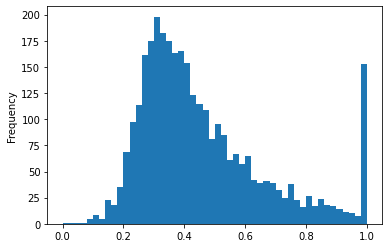

In [43]:
df.phonetic_ev.plot.hist(bins=50)